# Declaration of Originality

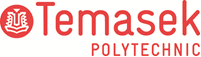

**TEMASEK POLYTECHNIC**
<br>**SCHOOL OF INFORMATICS & IT**
<br>**DIPLOMA IN INFORMATION TECHNOLOGY**
<br>**MACHINE LEARNING FOR DEVELOPERS (CAI2C08)**
<br>**AY2025/2026 OCTOBER SEMESTER**

**PROJECT PROGRAM CODES**
* Student Name (Matric Number)  :
* Tutorial Group                :  
* Tutor						    :  
* Submission Date               : 


**Declaration of Originality**
* I am the originator of this work and I have appropriately acknowledged all other original sources used as my references for this work.
* I understand that Plagiarism is the act of taking and using the whole or any part of another person’s work, including work generated by AI, and presenting it as my own.
* I understand that Plagiarism is an academic offence and if I am found to have committed or abetted the offence of plagiarism in relation to this submitted work, disciplinary action will be enforced.

# Libraries

In [1]:
## Import libraries
import pandas as pd 
import sklearn as sk
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


# 1. Business Understanding
Goal: ?

# 2. Data Understanding

## 2.1 Load dataset

In [2]:
FILE_PATH = "SG_used_car.csv"
df = pd.read_csv(FILE_PATH)


## 2.2 Summary Statistics

In [3]:
## Understand the type of variable for each column
df.info()

## Check for missing data
df.isna().sum()

## Describe data distribution
df.describe(include="all")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4411 entries, 0 to 4410
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Brand          4411 non-null   object 
 1   Type           4411 non-null   object 
 2   Reg_date       4411 non-null   object 
 3   Coe_left       4389 non-null   object 
 4   Dep            4411 non-null   object 
 5   Mileage        4411 non-null   object 
 6   Road Tax       4411 non-null   object 
 7   Dereg Value    4411 non-null   object 
 8   COE            4411 non-null   object 
 9   Engine Cap     4411 non-null   object 
 10  Curb Weight    4411 non-null   object 
 11  Manufactured   4411 non-null   object 
 12  Transmission   4411 non-null   object 
 13  OMV            4411 non-null   object 
 14  ARF            4411 non-null   object 
 15  Power          4411 non-null   object 
 16  No. of Owners  4411 non-null   object 
 17  Price          4411 non-null   object 
 18  Unnamed:

,Unnamed: 18
count,1.500000e+01
mean,4.140886e+05
std,5.044258e+05
min,1.059880e+05
25%,1.919000e+05
50%,2.068000e+05
75%,2.698880e+05
max,1.690000e+06


In [4]:
## Missing data summary (count + %)
missing_summary = pd.DataFrame({
    "missing_count": df.isna().sum(),
    "missing_pct": (df.isna().mean() * 100).round(2)
})
missing_summary.sort_values("missing_pct", ascending=False)


Brand               0
Type                0
Reg_date            0
Coe_left           22
Dep                 0
Mileage             0
Road Tax            0
Dereg Value         0
COE                 0
Engine Cap          0
Curb Weight         0
Manufactured        0
Transmission        0
OMV                 0
ARF                 0
Power               0
No. of Owners       0
Price               0
Unnamed: 18      4396
dtype: int64

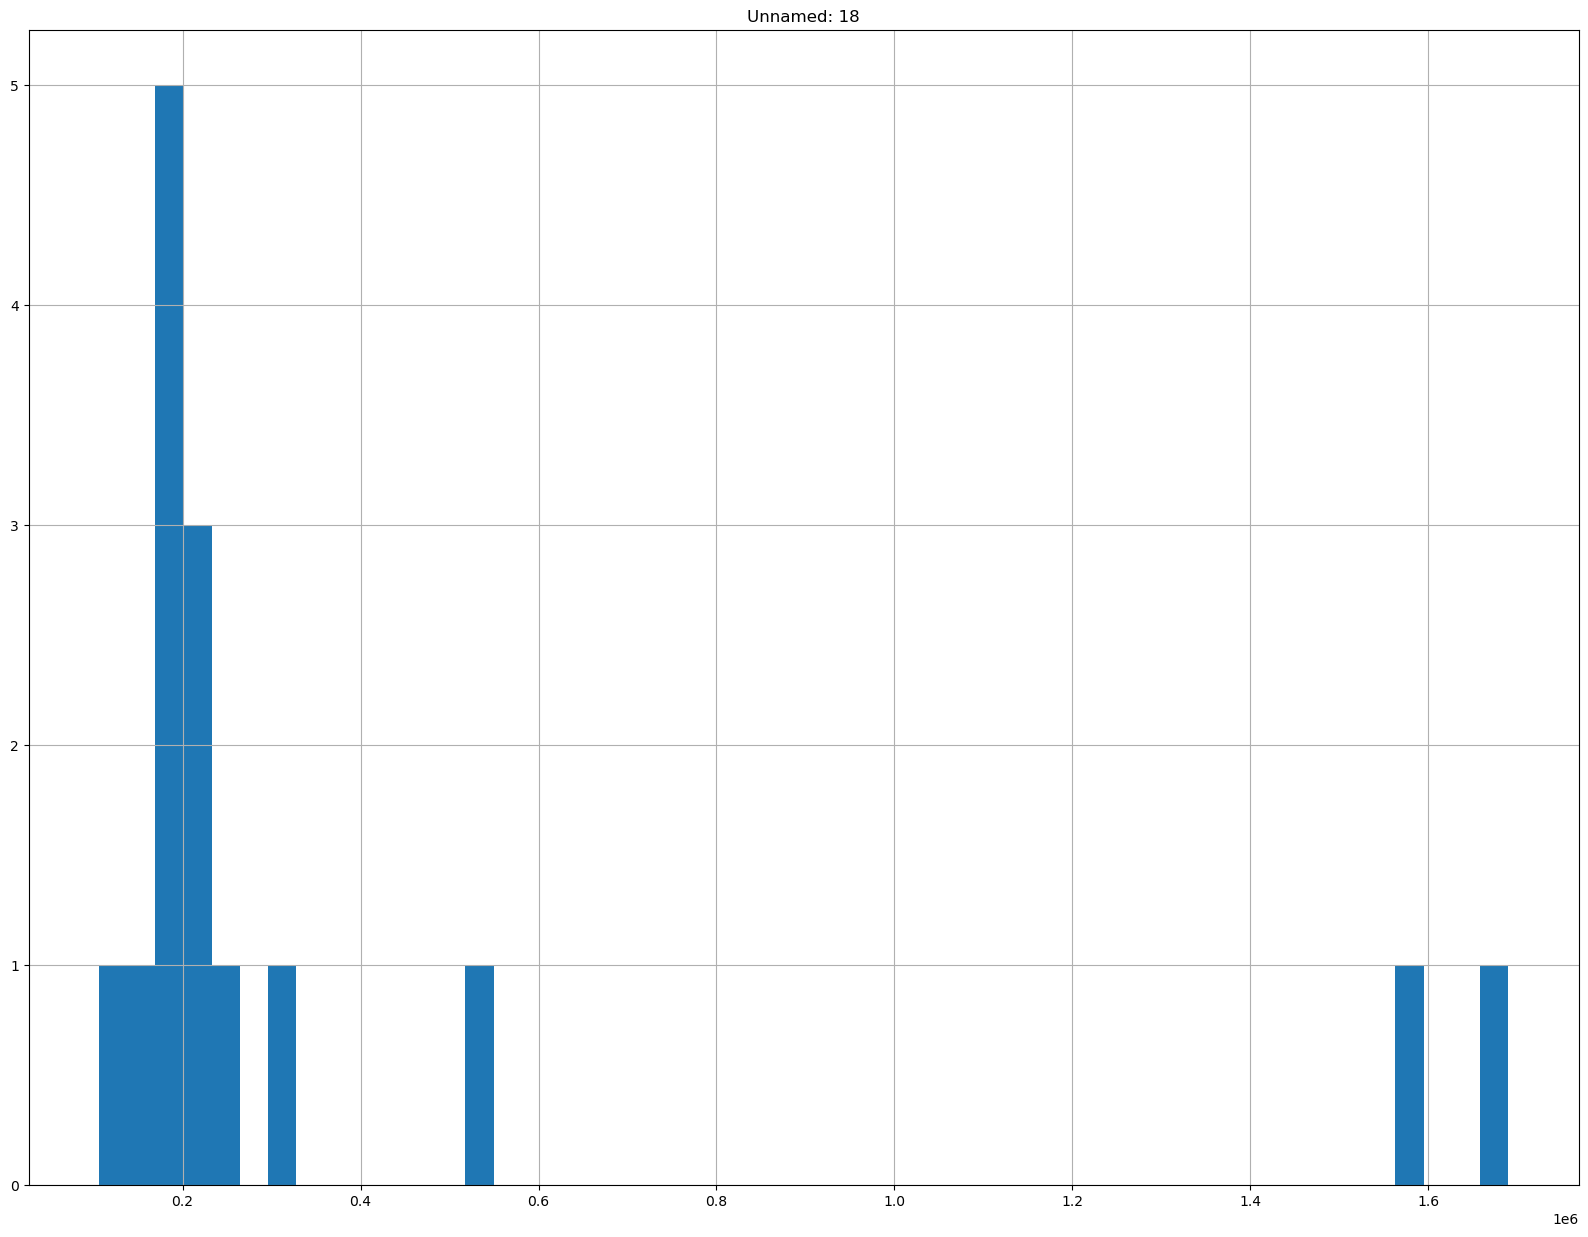

In [5]:
## Data quality check and EDA copy
df_raw = df.copy()
df_eda = df_raw.copy()

# Standardize missing value tokens seen in this dataset
df_eda = df_eda.replace(["N.A", "N.A.", "NA", "na", "-", ""], np.nan)

# These rows are malformed due to column shift during scraping/export
malformed_mask = df_eda["Unnamed: 18"].notna() if "Unnamed: 18" in df_eda.columns else pd.Series(False, index=df_eda.index)
print("Malformed rows detected:", int(malformed_mask.sum()))

# Column relevance decision for EDA/modeling
irrelevant_cols = ["Unnamed: 18"] if "Unnamed: 18" in df_eda.columns else []
leakage_risk_cols = ["Dep"] if "Dep" in df_eda.columns else []
high_cardinality_raw_cols = ["Brand"] if "Brand" in df_eda.columns else []
print("Irrelevant columns:", irrelevant_cols)
print("Leakage-risk column(s):", leakage_risk_cols)
print("Will engineer from noisy raw columns:", high_cardinality_raw_cols)

# Build clean EDA frame
df_eda = df_eda.loc[~malformed_mask].drop(columns=irrelevant_cols, errors="ignore")
print("Clean EDA shape:", df_eda.shape)


## 2.3 Data Visualization

### 2.3.1 Understanding distribution of data

In [6]:
## Prepare columns for visualization
numeric_cols = [
    "Dep", "Mileage", "Road Tax", "Dereg Value", "COE", "Engine Cap",
    "Curb Weight", "Manufactured", "OMV", "ARF", "Power", "No. of Owners", "Price"
]
numeric_cols = [c for c in numeric_cols if c in df_eda.columns]

for c in numeric_cols:
    df_eda[c] = pd.to_numeric(df_eda[c], errors="coerce")

# Power has some concatenated values (e.g., 2207) from raw source; mark extreme values as missing
if "Power" in df_eda.columns:
    df_eda.loc[df_eda["Power"] > 1000, "Power"] = np.nan


# Convert registration date -> vehicle age (more useful than raw date)
if "Reg_date" in df_eda.columns:
    df_eda["Reg_date"] = pd.to_datetime(df_eda["Reg_date"], format="%d-%b-%y", errors="coerce")
    df_eda["Vehicle_Age"] = (pd.Timestamp("today") - df_eda["Reg_date"]).dt.days / 365.25

# Extract main brand to reduce cardinality from full car title
if "Brand" in df_eda.columns:
    df_eda["Brand_Main"] = df_eda["Brand"].astype(str).str.split().str[0]

# Parse COE left text into numeric years (if available)
if "Coe_left" in df_eda.columns:
    temp = df_eda["Coe_left"].astype(str).str.lower()
    yrs = pd.to_numeric(temp.str.extract(r"(\d+)\s*yr")[0], errors="coerce").fillna(0)
    mths = pd.to_numeric(temp.str.extract(r"(\d+)\s*mth")[0], errors="coerce").fillna(0)
    days = pd.to_numeric(temp.str.extract(r"(\d+)\s*day")[0], errors="coerce").fillna(0)
    df_eda["COE_Left_Years"] = yrs + (mths / 12) + (days / 365)

print(df_eda[numeric_cols].describe().T[["count", "mean", "std", "min", "50%", "max"]])


Dataset shape: (4411, 19)
Number of ros: 4411
Number of columns: 19


### 2.3.1.1 Understanding distribution of target

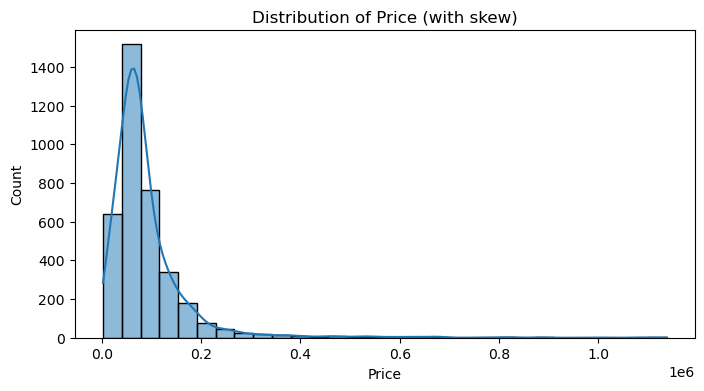

Skew: 4.8150792671598355


In [7]:
## Understanding distribution of target
col_y = "Price"
target = df_eda[col_y].dropna()

# Left: zoom at 99th percentile so bars are close together. Right: log view to show skew clearly.
p99 = target.quantile(0.99)
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.histplot(target[target <= p99], bins=45, kde=True, ax=axes[0])
axes[0].set_title("Price Distribution (<= 99th percentile)")
axes[0].set_xlabel("Price")
axes[0].set_ylabel("Number of cars")

sns.histplot(np.log1p(target), bins=45, kde=True, ax=axes[1])
axes[1].set_title("log(Price + 1) Distribution")
axes[1].set_xlabel("log(Price + 1)")
axes[1].set_ylabel("Number of cars")

plt.tight_layout()
plt.show()

print("Skew (raw price):", round(target.skew(), 3))
print("Skew (log price):", round(np.log1p(target).skew(), 3))


### 2.3.1.2 Understanding distribution of features

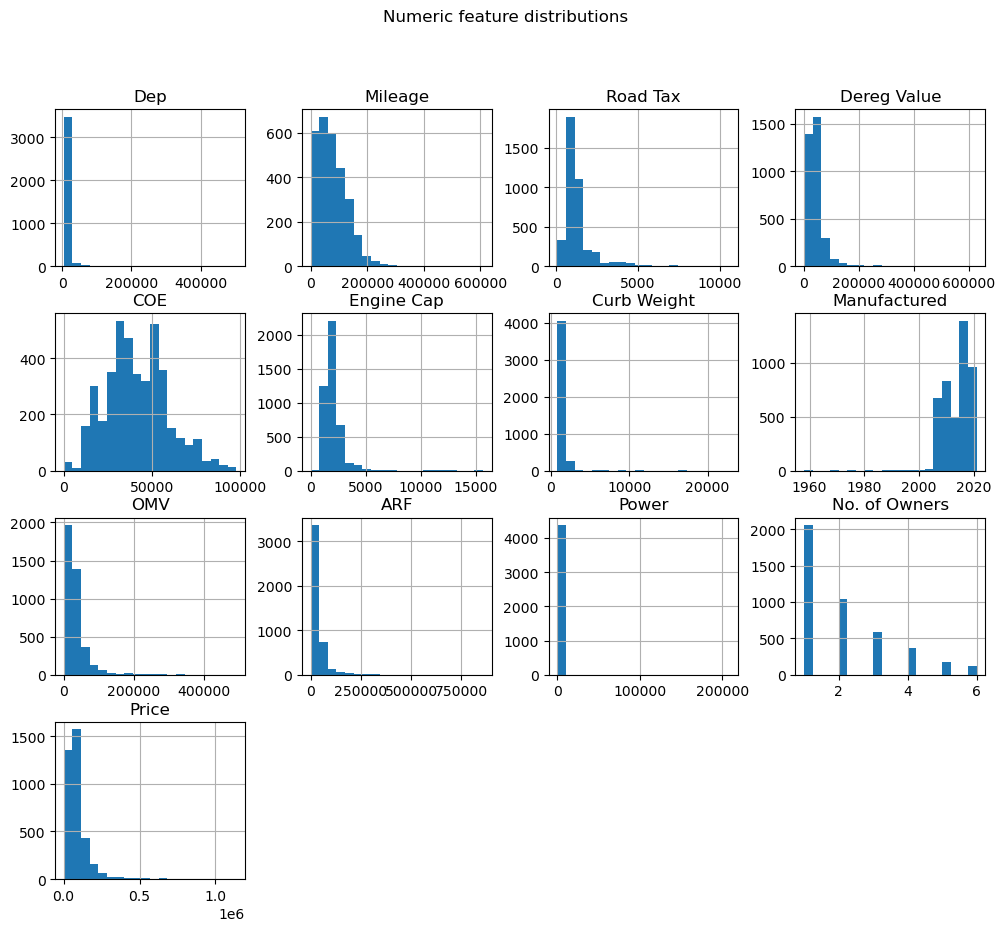

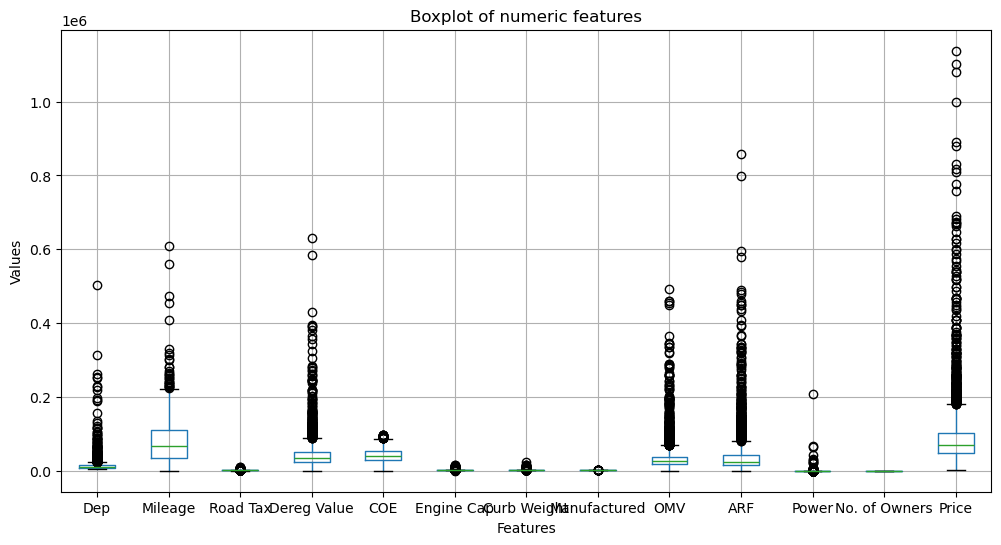

In [8]:
## Understanding distribution of features
num_features = [
    "Mileage", "Road Tax", "Dereg Value", "COE", "Engine Cap",
    "Curb Weight", "OMV", "ARF", "Power", "No. of Owners", "Vehicle_Age", "COE_Left_Years"
]
num_features = [c for c in num_features if c in df_eda.columns]

df_eda[num_features].hist(layout=(3, 4), figsize=(12, 8), bins=30)
plt.suptitle("Numeric feature distributions", y=1.02)
plt.tight_layout()
plt.show()

df_eda[num_features].boxplot(rot=45, figsize=(12, 4))
plt.yscale("log")
plt.title("Numeric feature boxplots (log scale)")
plt.suptitle("")
plt.xlabel("Features")
plt.ylabel("Value (log scale)")
plt.show()

# Categorical distribution for key columns
for col in ["Type", "Transmission", "Brand_Main"]:
    if col in df_eda.columns:
        plt.figure(figsize=(8, 3))
        df_eda[col].value_counts().head(10).plot(kind="bar")
        plt.title(f"Top 10 categories in {col}")
        plt.suptitle("")
        plt.xlabel(col)
        plt.ylabel("Count")
        plt.xticks(rotation=45, ha="right")
        plt.tight_layout()
        plt.show()


### 2.3.2 Understanding relationship between variables

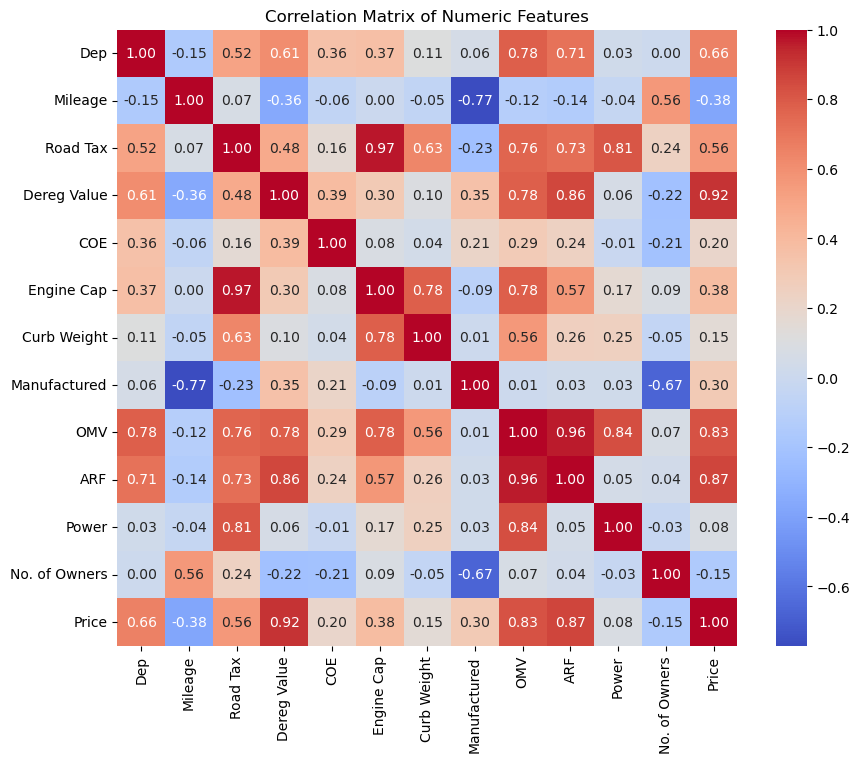

In [9]:
## Understanding relationship between variables
col_y = "Price"
key_x = ["OMV", "ARF", "Dereg Value", "Mileage", "Vehicle_Age", "COE"]
key_x = [c for c in key_x if c in df_eda.columns]

for col_x in key_x:
    df_eda.plot(x=col_x, y=col_y, kind="scatter", alpha=0.4, figsize=(5, 3))
    plt.title(f"{col_x} vs {col_y}")
    plt.suptitle("")
    plt.xlabel(col_x)
    plt.ylabel(col_y)
    plt.show()

# Correlation heatmap (numeric columns only)
corr_cols = [c for c in num_features + [col_y] if c in df_eda.columns]
df_corr = df_eda[corr_cols].corr(numeric_only=True)
plt.figure(figsize=(10, 6))
sns.heatmap(df_corr, cmap="RdYlGn", annot=True, fmt=".2f")
plt.title("Correlation Heatmap (numeric features)")
plt.show()

# Optional categorical relationship (price by vehicle type)
if "Type" in df_eda.columns:
    top_types = df_eda["Type"].value_counts().head(8).index
    plt.figure(figsize=(10, 4))
    sns.boxplot(data=df_eda[df_eda["Type"].isin(top_types)], x="Type", y="Price")
    plt.yscale("log")
    plt.title("Price by Type (top 8, log scale)")
    plt.xlabel("Type")
    plt.ylabel("Price")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()


# 3. Data Preparation

## 3.1 Data Cleaning

In [ ]:
## Clean dataset for modeling
col_y = "Price"
df_model = df.copy()

# Standardize missing values
df_model = df_model.replace(["N.A", "N.A.", "NA", "na", "-", ""], np.nan)

# Remove malformed rows created by shifted columns in raw data
if "Unnamed: 18" in df_model.columns:
    df_model = df_model[df_model["Unnamed: 18"].isna()].copy()

# Convert numeric-like columns to numeric
numeric_cols = ["Dep", "Mileage", "Road Tax", "Dereg Value", "COE", "Engine Cap",
               "Curb Weight", "Manufactured", "OMV", "ARF", "Power", "No. of Owners", "Price"]
numeric_cols = [c for c in numeric_cols if c in df_model.columns]
for c in numeric_cols:
    df_model[c] = pd.to_numeric(df_model[c], errors="coerce")

# Power has concatenated values in some rows (e.g., 2207), treat as invalid
if "Power" in df_model.columns:
    df_model.loc[df_model["Power"] > 1000, "Power"] = np.nan

# Feature engineering from raw text columns
if "Reg_date" in df_model.columns:
    df_model["Reg_date"] = pd.to_datetime(df_model["Reg_date"], format="%d-%b-%y", errors="coerce")
    df_model["Vehicle_Age"] = (pd.Timestamp("today") - df_model["Reg_date"]).dt.days / 365.25

if "Brand" in df_model.columns:
    df_model["Brand_Main"] = df_model["Brand"].astype(str).str.split().str[0]

if "Coe_left" in df_model.columns:
    temp = df_model["Coe_left"].astype(str).str.lower()
    yrs = pd.to_numeric(temp.str.extract(r"(\d+)\s*yr")[0], errors="coerce").fillna(0)
    mths = pd.to_numeric(temp.str.extract(r"(\d+)\s*mth")[0], errors="coerce").fillna(0)
    days = pd.to_numeric(temp.str.extract(r"(\d+)\s*day")[0], errors="coerce").fillna(0)
    df_model["COE_Left_Years"] = yrs + (mths / 12) + (days / 365)

# Keep only rows with target value for supervised learning
df_model = df_model.dropna(subset=[col_y]).copy()

# Clean rare invalid transmission tokens
if "Transmission" in df_model.columns:
    valid_trans = ["Auto", "Manual", "Petrol-Electric", "Electric"]
    df_model["Transmission"] = df_model["Transmission"].where(df_model["Transmission"].isin(valid_trans), np.nan)

# Fill missing values before encoding
col_numeric = df_model.select_dtypes(include=["int64", "float64"]).columns
col_categorical = df_model.select_dtypes(include=["object"]).columns
df_model[col_numeric] = df_model[col_numeric].fillna(df_model[col_numeric].median(numeric_only=True))
for col in col_categorical:
    if df_model[col].isna().sum() > 0:
        df_model[col] = df_model[col].fillna(df_model[col].mode().iloc[0])

print("Cleaned dataset shape:", df_model.shape)
df_model.isna().sum().sort_values(ascending=False).head(10)


In [ ]:
## Check datatypes for each column
df_model.dtypes

col_categorical = df_model.select_dtypes(include=["object"]).columns ## Select all categorical columns

## Print data about categorical column
'''
nunique(): Return total number of unique values in column
unique(): Return unique values in column
'''
# Labsheet style prints all unique values; for very high-cardinality columns we show a preview only.
for col in df_model[col_categorical]:
    nunique = df_model[col].nunique()
    unique_vals = df_model[col].dropna().unique()
    preview = unique_vals[:15] if nunique > 30 else unique_vals
    print(f"{col} ({nunique}): {preview}")

## Split data into features (X) and target (y)
y = df_model[col_y] ## Select target column

# Feature policy for consumer-facing predictor:
# Drop volatile policy/valuation columns and fetch them by API later at inference if needed.
col_dynamic_market = ["COE", "COE_Left_Years", "OMV", "ARF", "Dereg Value"]

# Drop columns that are irrelevant/noisy/leakage-prone for prediction
# Dep is dropped to reduce leakage risk; Reg_date/Coe_left/Brand replaced by engineered features.
col_irrelevant = [col_y, "Unnamed: 18", "Reg_date", "Coe_left", "Brand", "Dep"] + col_dynamic_market
col_irrelevant = [col for col in col_irrelevant if col in df_model.columns]

X = df_model.drop(col_irrelevant, axis=1) ## Select feature columns

## One-Hot Encoding
X = pd.get_dummies(X, 
                   drop_first=True ## Remove redundant information
                   )
print("Final features used:", X.shape[1])
X


## 3.2 Train-Test Split

In [11]:
from sklearn.model_selection import train_test_split

## Split data into train set and test set
test_size = 0.3
random_state = 2025 ## For reproducibility
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=test_size, 
                                                    random_state=random_state)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)


# 4. Modelling

### 4.2 Train Model

In [12]:
## Initialise and train model
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

## Model 1: Linear Regression (baseline)
linr = LinearRegression(fit_intercept=True)
linr.fit(X_train, y_train)

## Model 2: Random Forest Regressor
rf = RandomForestRegressor(n_estimators=300, random_state=2025, n_jobs=-1)
rf.fit(X_train, y_train)

print("Training complete: Linear Regression and Random Forest")


# 5. Model Evaluation

In [13]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

## Evaluate model 1
y_pred_linr = linr.predict(X_test) ## Prediction using model 1
E_linr = y_pred_linr - y_test ## Calculate error
print("Linear Regression Errors (first 10):")
print(E_linr.head(10))
print("Linear Regression MAE:", mean_absolute_error(y_test, y_pred_linr))
print("Linear Regression MSE:", mean_squared_error(y_test, y_pred_linr))
print("Linear Regression RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_linr)))
print("Linear Regression R2:", r2_score(y_test, y_pred_linr))

## Evaluate model 2
y_pred_rf = rf.predict(X_test) ## Prediction using model 2
E_rf = y_pred_rf - y_test ## Calculate error
print("\nRandom Forest Errors (first 10):")
print(E_rf.head(10))
print("Random Forest MAE:", mean_absolute_error(y_test, y_pred_rf))
print("Random Forest MSE:", mean_squared_error(y_test, y_pred_rf))
print("Random Forest RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_rf)))
print("Random Forest R2:", r2_score(y_test, y_pred_rf))

## Comparison table
df_eval = pd.DataFrame({
    "Model": ["Linear Regression", "Random Forest"],
    "MAE": [mean_absolute_error(y_test, y_pred_linr), mean_absolute_error(y_test, y_pred_rf)],
    "MSE": [mean_squared_error(y_test, y_pred_linr), mean_squared_error(y_test, y_pred_rf)],
    "RMSE": [np.sqrt(mean_squared_error(y_test, y_pred_linr)), np.sqrt(mean_squared_error(y_test, y_pred_rf))],
    "R2": [r2_score(y_test, y_pred_linr), r2_score(y_test, y_pred_rf)]
})
print("\nModel comparison:")
print(df_eval.sort_values("MAE"))

baseline_model_name = "Linear Regression"
current_best_model_name = "Random Forest" if mean_absolute_error(y_test, y_pred_rf) < mean_absolute_error(y_test, y_pred_linr) else "Linear Regression"
current_best_model = rf if current_best_model_name == "Random Forest" else linr
print("\nCurrent best model before tuning:", current_best_model_name)
print("Business metric used: MAE (average SGD prediction error).")


In [14]:
## New data
# For demonstration, we reuse cleaned data schema and predict with current best model.
X_unseen = df_model.drop([col_y], axis=1).copy()

col_dynamic_market = ["COE", "COE_Left_Years", "OMV", "ARF", "Dereg Value"]
col_irrelevant_unseen = ["Unnamed: 18", "Reg_date", "Coe_left", "Brand", "Dep"] + col_dynamic_market
col_irrelevant_unseen = [col for col in col_irrelevant_unseen if col in X_unseen.columns]
X_unseen = X_unseen.drop(col_irrelevant_unseen, axis=1)

## One-Hot Encoding and align columns with training data
X_unseen = pd.get_dummies(X_unseen, drop_first=True)
X_unseen = X_unseen.reindex(columns=X.columns, fill_value=0)

## Predict
df_prediction = pd.DataFrame()
df_prediction["Predicted Price"] = current_best_model.predict(X_unseen)
df_prediction["Actual Price"] = y.values
df_prediction.head(10)


## Iterative model development


In [15]:
## Hyperparameter tuning (vary 2 hyperparameters only)
from sklearn.model_selection import RandomizedSearchCV

param_dist_rf = {
    "n_estimators": [200, 400, 600],
    "max_depth": [10, 20, None]
}

rs_rf = RandomizedSearchCV(estimator=RandomForestRegressor(random_state=2025),
                           param_distributions=param_dist_rf,
                           n_iter=9,
                           cv=3,
                           scoring="neg_mean_absolute_error",
                           random_state=2025,
                           n_jobs=1)

rs_rf.fit(X_train, y_train)
best_rs_params = rs_rf.best_params_
best_rs_rf = rs_rf.best_estimator_
print("Best Parameters:", best_rs_params)
print("Best Estimator:", best_rs_rf)

## Detailed tuning logs/table
df_tuning_logs = pd.DataFrame(rs_rf.cv_results_)[[
    "param_n_estimators", "param_max_depth", "mean_test_score", "std_test_score", "rank_test_score"
]].sort_values("rank_test_score")
print("\nRandomizedSearchCV logs (top rows):")
print(df_tuning_logs.head(10))

## Evaluate tuned model
y_pred_rs_rf = best_rs_rf.predict(X_test)
E_rs_rf = y_pred_rs_rf - y_test
print("\nTuned RF Errors (first 10):")
print(E_rs_rf.head(10))
print("Tuned RF MAE:", mean_absolute_error(y_test, y_pred_rs_rf))
print("Tuned RF MSE:", mean_squared_error(y_test, y_pred_rs_rf))
print("Tuned RF RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_rs_rf)))
print("Tuned RF R2:", r2_score(y_test, y_pred_rs_rf))


In [ ]:
## Compare baseline vs untuned vs tuned
mae_linr = mean_absolute_error(y_test, y_pred_linr)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
mae_tuned = mean_absolute_error(y_test, y_pred_rs_rf)
df_compare = pd.DataFrame({
    "Model": ["Linear Regression (Baseline)", "Random Forest (Untuned)", "Random Forest (Tuned)"],
    "MAE": [mae_linr, mae_rf, mae_tuned],
    "RMSE": [
        np.sqrt(mean_squared_error(y_test, y_pred_linr)),
        np.sqrt(mean_squared_error(y_test, y_pred_rf)),
        np.sqrt(mean_squared_error(y_test, y_pred_rs_rf))
    ],
    "R2": [
        r2_score(y_test, y_pred_linr),
        r2_score(y_test, y_pred_rf),
        r2_score(y_test, y_pred_rs_rf)
    ]
}).sort_values("MAE")
print(df_compare)
improvement_vs_baseline = mae_linr - min(mae_rf, mae_tuned)
print("\nMAE improvement vs baseline (Linear Regression):", improvement_vs_baseline)
if mae_tuned < mae_rf:
    final_model = best_rs_rf
    final_model_name = "Random Forest (Tuned)"
else:
    final_model = rf
    final_model_name = "Random Forest (Untuned)"
print("Final selected model:", final_model_name)
# Impact explanation (for report):
print("Impact: Lower MAE means lower average pricing error in SGD, so valuation advice is more reliable.")
## Save lightweight deployment model for Streamlit (smaller file size)
from sklearn.tree import DecisionTreeRegressor
import joblib
deploy_model = DecisionTreeRegressor(max_depth=10, random_state=2025)
deploy_model.fit(X_train, y_train)
y_pred_deploy = deploy_model.predict(X_test)
print("Deploy Model (Decision Tree) MAE:", mean_absolute_error(y_test, y_pred_deploy))
print("Deploy Model (Decision Tree) RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_deploy)))
print("Deploy Model (Decision Tree) R2:", r2_score(y_test, y_pred_deploy))
MODEL_PATH = "car_price_model.pkl"
joblib.dump(deploy_model, MODEL_PATH, compress=3)
print("Lightweight model saved:", MODEL_PATH)
